<a href="https://colab.research.google.com/github/mabelc/forcasting/blob/master/notebooks/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA

ARIMA, acronym of ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors. ARIMA models aim to describe the autocorrelations in the data.

## Data transformation

If the data show variation that increases or decreases with the level of the series, then a transformation can be useful. A useful family of transformations, that includes both logarithms and power transformations, is the family of Box-Cox transformations, which depend on the parameter $\lambda$ and are defined as follows:

* $\lambda=0, w_t=log( y_t)$
* $\lambda\neq0, w_t=(y^\lambda_t-1)/\lambda$

A good value of $\lambda$ is one which makes the size of the seasonal variation about the same across the whole series, as that makes the forecasting model simpler.

We will find the best $\lambda$ to transform Australian monthly electricity production:

In [0]:
!pip install tscv

In [0]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 8.7MB 16.1MB/s 
     |████████████████████████████████| 2.1MB 42.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.19
    Uninstalling Cython-0.29.19:
      Successfully uninstalled Cython-0.29.19


In [0]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tscv
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima, ARIMA
from tscv import GapWalkForward
from rpy2.robjects import pandas2ri, r
from scipy.stats import boxcox
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [0]:
# install fpp2 package
utils = importr('utils')
utils.install_packages('fpp2')

In [0]:
# get the data and create dataframe
ro.r('library(fpp2)')
elec_np = r('elec')
elec_df = pd.DataFrame(elec_np, index=pd.date_range(start='1/1/1956',  periods=476, freq='M'), columns=['production'])

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: forecast

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Loading required package: fma

R[write to console]: Loading required package: expsmooth



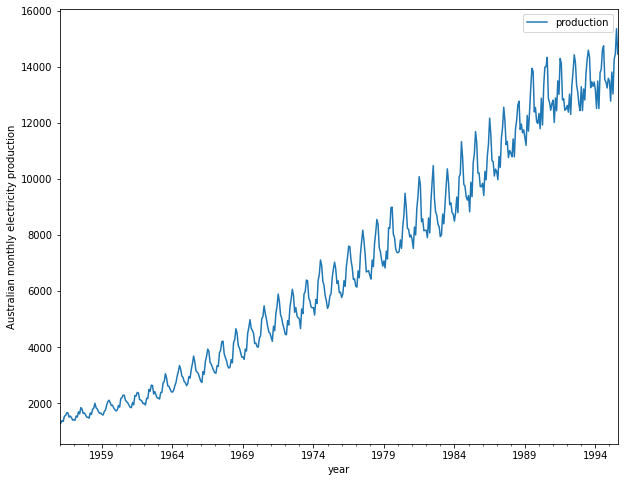

In [0]:
# plot data
elec_df.plot(figsize=(10,8))
plt.xlabel('year')
plt.ylabel('Australian monthly electricity production')
plt.show()

The data show variation that increases with the years. We use the function **boxcox** to transform the data:

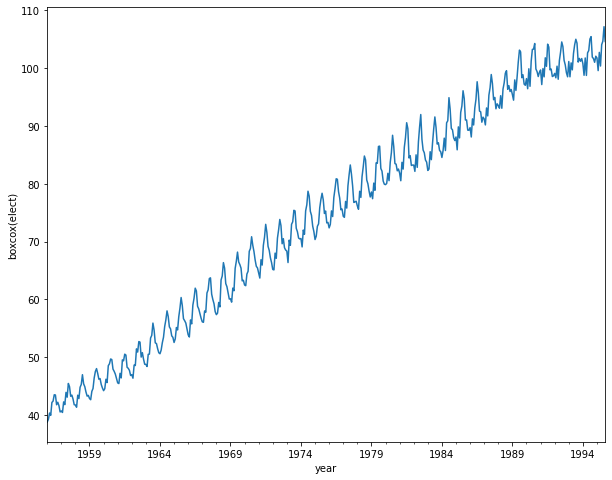

Lambda value is:  0.3896252316581785


In [0]:
# estimate lambda and transform the data
elec_transf = boxcox(elec_df.production)
elec_df['boxcox'] = elec_transf[0]

# plot data
elec_df.boxcox.plot(figsize=(10,8))
plt.xlabel('year')
plt.ylabel('boxcox(elect)')
plt.show()

print('Lambda value is: ', elec_transf[1])

## Non-Seasonal ARIMA models

 ARIMA models combine differencing, autoregresion and moving average model. The full model can be written as:

 $y^{'}_{t}=c+\phi_{1} y^{'}_{t-1}+...+\phi_{p} y^{'}_{t-p}+\theta_{1} \epsilon_{t-1} +...+ \theta_{q} \epsilon_{t-q}+\epsilon_{t}$

 Where $y^{'}_{t}$ is the differenced series. This model is called ARIMA($p,d,q$) model where:

 * $p$ = order of the autoregressive part
 * $d$ = degree of first differencing involved
 * $q$ = order of the moving average part

We will use the quarterly percentage changes in US consumption expenditure to fit a non-seasonal ARIMA. 

In [0]:
# get the data and create dataframe

us_np = r('uschange[,"Consumption"]')
index= pd.date_range(start='1970', end='2017', freq='Q')[0:-1]
us_df = pd.DataFrame(us_np, index)
us_df.columns = ['consumption']

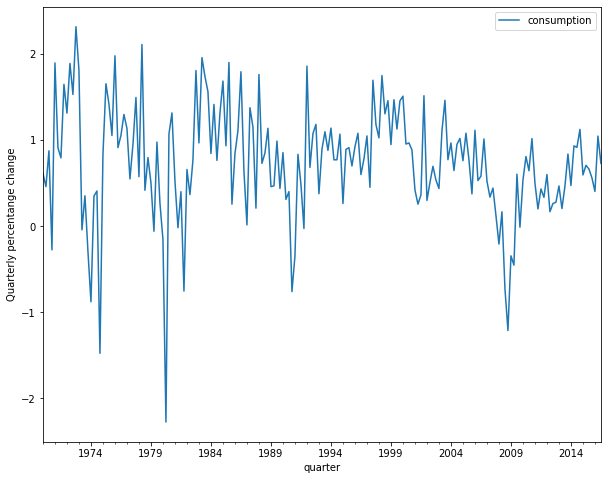

In [0]:
# plot data
us_df.plot(figsize=(10,8))
plt.xlabel('quarter')
plt.ylabel('Quarterly percentange change')
plt.show()

Pmdarima package brings R's auto.arima functionality to Python by wrapping statsmodel ARIMA and SARIMAX models. We will search the best model by minimizing the Akaike Information Criterion. We define the search range of the parameters $p$ and $q$.

In [0]:
# fitting a stepwise model:
stepwise_fit = auto_arima(us_df.consumption, start_p=1, start_q=1, max_p=3, max_q=3, m=4,
                             seasonal=False, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=343.815, BIC=356.740, Time=0.281 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=375.632, BIC=382.095, Time=0.042 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=353.332, BIC=363.025, Time=0.049 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=360.371, BIC=370.064, Time=0.116 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=529.744, BIC=532.975, Time=0.023 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=344.493, BIC=360.649, Time=0.162 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=343.330, BIC=359.485, Time=0.137 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=356.797, BIC=369.721, Time=0.078 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=342.284, BIC=361.671, Time=0.250 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=342.536, BIC=365.154, Time=0.286 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=343.179

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -164.807
Date:                Wed, 03 Jun 2020   AIC                            341.613
Time:                        09:05:29   BIC                            361.000
Sample:                             0   HQIC                           349.469
                                - 187                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3066      0.096      3.199      0.001       0.119       0.494
ar.L1          0.5887      0.132      4.458      0.000       0.330       0.847
ma.L1         -0.3529      0.138     -2.552      0.011      -0.624      -0.082
ma.L2          0.0846      0.065      1.309      0.190      -0.042       0.211
ma.L3          0.1738      0.079      2.214      0.027       0.020       0.328
sigma2         0.3405      0.025     13.646      0.000       0.292       0.389
===================================================================================
Ljung-Box (Q):                       41.41   Jarque-Bera (JB):                64.65
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best model found is ARIMA(1,0,3). Attending the parameters provided (**intercept**, **ar.L1**, **ma.L1**, **ma.L2**, **ma.L3**), the model can be expressed as:

$y^{'}_{t}= 0.307 + 0.589 y^{'}_{t-1}-0.353 \epsilon_{t-1} +0.085\epsilon_{t-2} + 0.174 \epsilon_{t-3}+\epsilon_{t}$

If we know in advance the parameters, we can call directly the function _ARIMA_.

In [0]:
# fit ARIMA model

arima_model = ARIMA(order=(1,0,3), seasonal_order=(0,0,0,4))
arima_fit = arima_model.fit(us_df.consumption)
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -164.807
Date:                Wed, 03 Jun 2020   AIC                            341.613
Time:                        09:05:33   BIC                            361.000
Sample:                             0   HQIC                           349.469
                                - 187                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3066      0.096      3.199      0.001       0.119       0.494
ar.L1          0.5887      0.132      4.458      0.000       0.330       0.847
ma.L1         -0.3529      0.138     -2.552      0.011      -0.624      -0.082
ma.L2          0.0846      0.065      1.309      0.190      -0.042       0.211
ma.L3          0.1738      0.079      2.214      0.027       0.020       0.328
sigma2         0.3405      0.025     13.646      0.000       0.292       0.389
===================================================================================
Ljung-Box (Q):                       41.41   Jarque-Bera (JB):                64.65
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We predict future values as usual.

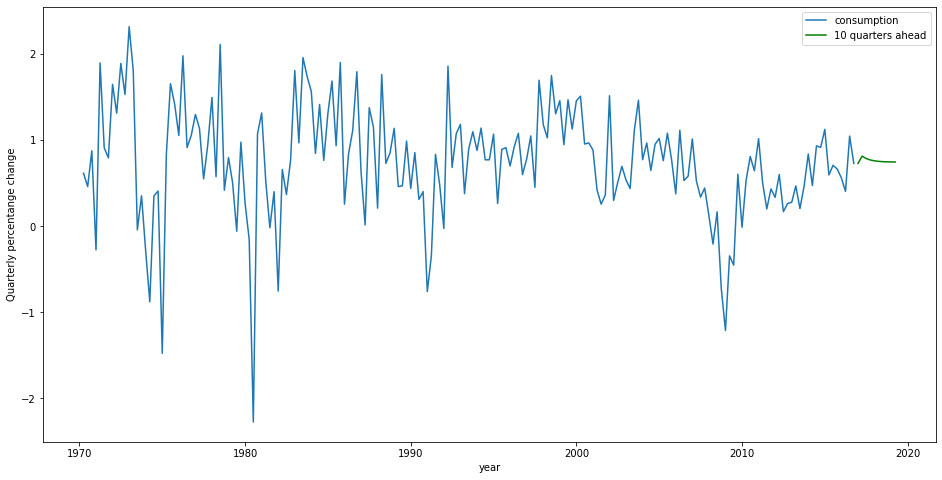

In [0]:
# predicting the next 10 values

predict_arima = arima_fit.predict(n_periods=10)
predict_arima

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(us_df.index, us_df.consumption.values, label='consumption')
ax.plot(pd.date_range(start='31/12/2016',  periods=10, freq='Q'), predict_arima, color="green", label='10 quarters ahead')
plt.ylabel('Quarterly percentange change') 
plt.xlabel('year') 
plt.legend();

The function **auto_arima** does not consider all possible models in its search. We can make it work harder by using the argument _stepwise_=FALSE. However, the stepwise algorithm can be significantly faster than fitting all hyper-parameter combinations and is less likely to over-fit the model so it would be our first choice. 

In [0]:
# fitting a stepwise model:
stepwise_fit = auto_arima(us_df.consumption, start_p=1, start_q=1, max_p=3, max_q=3, m=4,
                             seasonal=False, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=False)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=375.632, BIC=382.095, Time=0.039 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=360.371, BIC=370.064, Time=0.115 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=356.797, BIC=369.721, Time=0.077 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=342.758, BIC=358.914, Time=0.104 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=353.332, BIC=363.025, Time=0.058 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=343.815, BIC=356.740, Time=0.108 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=343.330, BIC=359.485, Time=0.140 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=341.613, BIC=361.000, Time=0.145 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=346.268, BIC=359.192, Time=0.075 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=344.493, BIC=360.649, Time=0.161 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=342.284, BIC=361.671, Time=0.248 seconds
Fit ARIMA(

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -165.170
Date:                Wed, 03 Jun 2020   AIC                            340.340
Time:                        09:05:46   BIC                            356.495
Sample:                             0   HQIC                           346.886
                                - 187                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3050      0.062      4.889      0.000       0.183       0.427
ar.L1          0.2275      0.058      3.946      0.000       0.114       0.340
ar.L2          0.1604      0.059      2.721      0.007       0.045       0.276
ar.L3          0.2027      0.067      3.025      0.002       0.071       0.334
sigma2         0.3419      0.024     13.957      0.000       0.294       0.390
===================================================================================
Ljung-Box (Q):                       40.42   Jarque-Bera (JB):                63.29
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model found now ARIMA(3,0,0) is slightly better than the previous one.

## Check the residuals

It is recommended to check if the residuals behave like white noise. If not the model is not considered good enough and we need to try a better adjustment.

We will check the residuals from the model fitted in the last section.

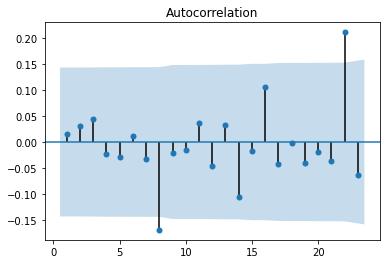

In [0]:
# ACF plot

plot_acf(stepwise_fit.resid(), zero=False)
plt.show()

The ACF plot shows that almost all autocorrelations are within the threshold limits except at 8 and 22 lags.

Ljung-Box test helps to determine if the residuals can be considered as white noise.

In [0]:
acorr_ljungbox(stepwise_fit.resid(), lags=22)[1]

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


array([0.83706513, 0.89061034, 0.89735152, 0.95196387, 0.9726573 ,
       0.98936592, 0.99297343, 0.56317635, 0.65240207, 0.73505147,
       0.78591574, 0.81595069, 0.85636131, 0.75476229, 0.80980814,
       0.71085661, 0.74600776, 0.8002396 , 0.82853768, 0.86528406,
       0.88754452, 0.39485601])

Ljung-Box test returns large p-values for all lags tested, also suggesting that the residuals are white noise.

## Seasonal ARIMA models

ARIMA models are also capable of modelling a wide range of seasonal data. A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA:

ARIMA(p,d,q)(P,D,Q)m

where m = number of observations per year. The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period.

We will fit a seasonal ARIMA model using quarterly European retail trade data from 1996 to 2011.

In [0]:
# get the data and create dataframe

eu_np = r('euretail')
index= pd.date_range(start='1996', end='2012', freq='Q')
eu_df = pd.DataFrame(eu_np, index)
eu_df.columns = ['retail']

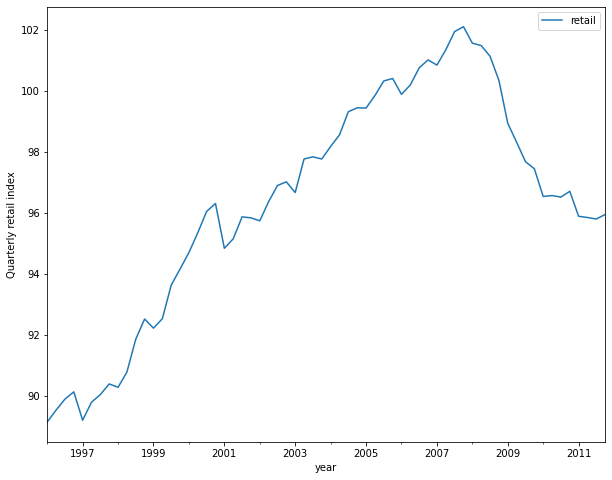

In [0]:
# plot data

eu_df.plot(figsize=(10,8))
plt.xlabel('year')
plt.ylabel('Quarterly retail index')
plt.show()

Now, we will find the best ARIMA model.

In [0]:
# fitting a stepwise model:
stepwise_fit = auto_arima(eu_df.retail, start_p=0, start_q=0, max_p=3, max_q=3, m=4,
                          seasonal=True, trace=True, start_P=0, max_P=3, d=1, D=1,
                          start_Q=0, max_Q=3,
                          information_criterion='aicc',
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=False)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA(0,1,0)x(0,1,0,4) [intercept=True]; AIC=97.169, BIC=101.324, Time=0.022 seconds
Fit ARIMA(0,1,0)x(0,1,1,4) [intercept=True]; AIC=75.972, BIC=82.204, Time=0.213 seconds
Fit ARIMA(0,1,0)x(0,1,2,4) [intercept=True]; AIC=77.209, BIC=85.519, Time=0.350 seconds
Fit ARIMA(0,1,0)x(0,1,3,4) [intercept=True]; AIC=78.959, BIC=89.347, Time=0.629 seconds
Fit ARIMA(0,1,0)x(1,1,0,4) [intercept=True]; AIC=87.143, BIC=93.376, Time=0.074 seconds
Fit ARIMA(0,1,0)x(1,1,1,4) [intercept=True]; AIC=77.147, BIC=85.457, Time=0.331 seconds
Fit ARIMA(0,1,0)x(1,1,2,4) [intercept=True]; AIC=79.538, BIC=89.925, Time=0.640 seconds
Fit ARIMA(0,1,0)x(1,1,3,4) [intercept=True]; AIC=79.752, BIC=92.217, Time=0.571 seconds
Fit ARIMA(0,1,0)x(2,1,0,4) [intercept=True]; AIC=87.014, BIC=95.324, Time=0.088 seconds
Fit ARIMA(0,1,0)x(2,1,1,4) [intercept=True]; AIC=79.133, BIC=89.520, Time=0.653 seconds
Fit ARIMA(0,1,0)x(2,1,2,4) [intercept=True]; AIC=79.899, BIC=92.364, Time=0.725 seconds
Fit ARIMA(0,1,0)x(2,1,3,4) [int

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   64
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 4)   Log Likelihood                 -27.746
Date:                             Wed, 03 Jun 2020   AIC                             67.492
Time:                                     13:15:15   BIC                             79.957
Sample:                                          0   HQIC                            72.358
                                              - 64                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0440      0.021     -2.116      0.034      -0.085      -0.003
ma.L1          0.1955      0.140      1.394      0.163      -0.079       0.470
ma.L2          0.2985      0.130      2.303      0.021       0.044       0.552
ma.L3          0.3837      0.134      2.862      0.004       0.121       0.646
ma.S.L4       -0.9887      2.036     -0.486      0.627      -4.980       3.002
sigma2         0.1231      0.241      0.511      0.609      -0.349       0.595
===================================================================================
Ljung-Box (Q):                       19.14   Jarque-Bera (JB):                 0.40
Prob(Q):                              1.00   Prob(JB):                         0.82
Heteroskedasticity (H):               0.61   Skew:                             0.18
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Ljung-Box test is used to know 

In [0]:
acorr_ljungbox(goog_df.Close, lags=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([991.45345747]), array([1.29414857e-217]))

In [0]:
acorr_ljungbox(np.diff(goog_df.Close.values), lags=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([1.50181123]), array([0.22039289]))

In [0]:
# fitting a stepwise model:
goog_fit = auto_arima(goog_df.Close.values, start_p=1, start_q=1, max_p=3, max_q=3, m=4,
                             seasonal=False, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

goog_fit.summary()

In [0]:
# fitting a stepwise model:
goog_fit = auto_arima(np.diff(goog_df.Close.values), start_p=1, start_q=1, max_p=3, max_q=3, m=4,
                             seasonal=False, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

goog_fit.summary()

In [0]:
# get the data
goog200_np = r('goog200')

In [0]:
result = kpss(goog_df.Close)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [0]:
result

(3.8259151271552114,
 0.01,
 22,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

In [0]:
result = kpss(np.diff(goog_df.Close))
result

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.03899142286011922,
 0.1,
 22,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})